In [1]:
#Importing required libraries

import pandas as pd
import dask
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 

In [2]:
# Loading data using pandas library

raw_tweets = pd.read_csv('sentiment_140/training.1600000.processed.noemoticon.csv', encoding='latin-1')

In [3]:
# Looking into the data

raw_tweets.columns = ['Target', 'ID', 'Date', 'Query', 'User', 'Text']

In [4]:
raw_tweets.head()

,Target,ID,Date,Query,User,Text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [5]:
# the most important thing is the text and the sentiment of it so we will get rid of the rest of the columns

raw_tweets = raw_tweets[['Target', 'Text']]

In [6]:
#Making sure we do not have duplicates

print(raw_tweets.shape)
raw_tweets.drop_duplicates(inplace = True)
print(raw_tweets.shape)

(1599999, 2)
(1583690, 2)


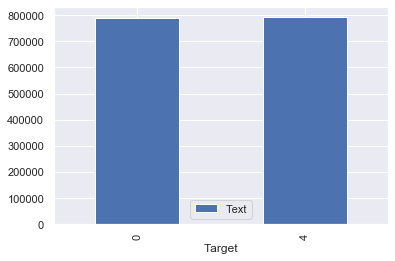

In [7]:
# Looking at the distribution of the tweets
raw_tweets.groupby('Target').count().plot(kind = 'bar')

In [8]:
#importing libraries for cleaning text
import nltk
import re
from collections import Counter

In [9]:
#creating a sample text
corpus = 'I ate 24 bananas and an 20$ @pple, WHIle Playing!!! *Volley*!'

In [10]:
#Creating a function to clean text and git rid of punctuations, stopwords, and lowering the text
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc


In [11]:
normalize_document(corpus)

'ate bananas pple playing volley'

In [12]:
# defining a function to clean the text in our dataframe.
def dataframe_normalize(row):
    row.Text = normalize_document(row.Text)
    return(row)

In [13]:
norm_tweets = raw_tweets.apply(dataframe_normalize,axis =1)
norm_tweets.Target.replace(4,1, inplace =True)

In [14]:
#Defining a function to count occurence of words in a given dataframe
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.Text.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame.from_dict(ct, orient='index')
    dfword = dfword.reset_index()
    dfword.columns = ["word","count"]
    dfword = dfword.sort_values("count",ascending=False)
    return(dfword)

In [16]:
dfword_pos = df_word(norm_tweets[norm_tweets.Target == 4])
dfword_neg = df_word(norm_tweets[norm_tweets.Target == 0])

Vocabulary Size: 518728
Vocabulary Size: 430668


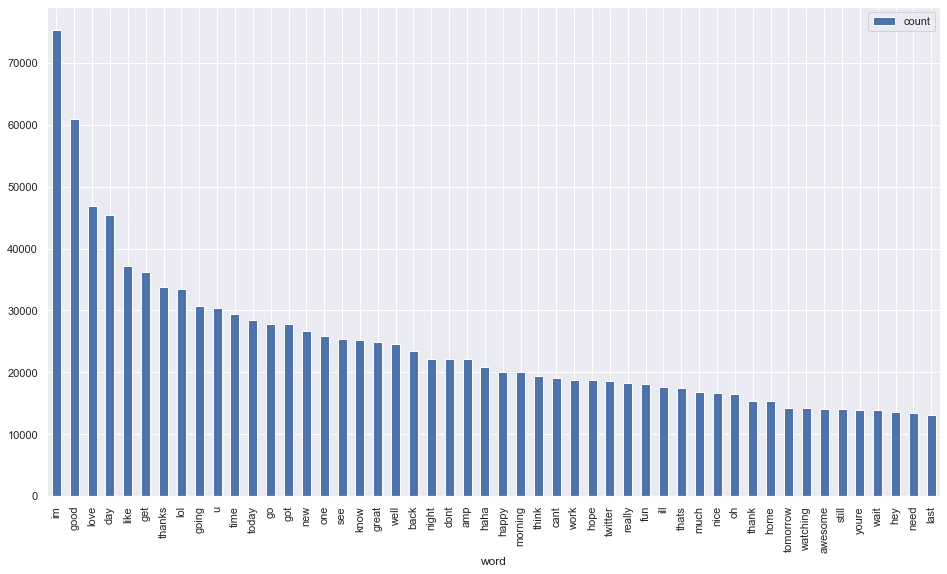

In [17]:
dfword_pos[:50].plot(x = 'word', y ='count', kind ='bar', figsize = (16,9))

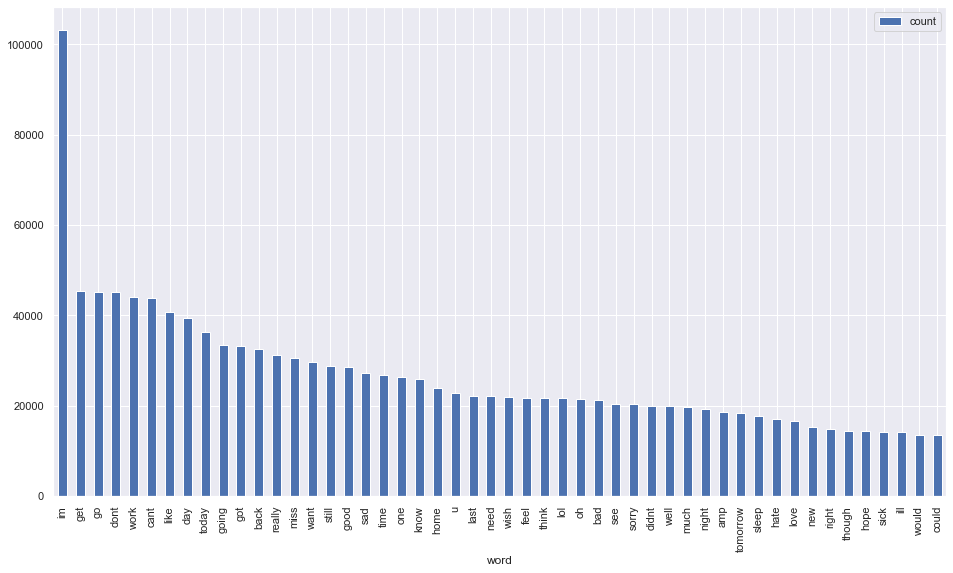

In [18]:
dfword_neg[:50].plot(x = 'word', y ='count', kind ='bar', figsize = (16,9))

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer

def vectorizer(df, bag_words = (1,1), test_size = 0.3):
    
    vector =HashingVectorizer(ngram_range= bag_words)
    X = df.Text.values
    y = df.Target.values
    X_vect = vector.fit_transform(X)
    x_train, x_test, y_train, y_test = train_test_split(X_vect, y, random_state=42, test_size=test_size)
    
    return(x_train, x_test, y_train, y_test)


In [16]:
x_train, x_test, y_train, y_test = vectorizer(norm_tweets, bag_words = (1,2))

In [17]:
from dask.distributed import Client 
client = Client() # start a local Dask client

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import joblib


with joblib.parallel_backend('dask'):

    lr = LogisticRegression()
    lr.fit(x_train,y_train)
print('Training Accuracy = {}'.format(lr.score(x_train, y_train)))
print('Test Accuracy = {}'.format(lr.score(x_test, y_test)))

C:\Users\a_raf\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\a_raf\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Training Accuracy = 0.8381997559046097
Test Accuracy = 0.7936780556800889


In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_test_pred = lr.predict(x_test)

print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[182339  54247]
 [ 43778 194743]]
              precision    recall  f1-score   support

           0       0.81      0.77      0.79    236586
           1       0.78      0.82      0.80    238521

    accuracy                           0.79    475107
   macro avg       0.79      0.79      0.79    475107
weighted avg       0.79      0.79      0.79    475107

